<a href="https://colab.research.google.com/github/yuji-sgs/child-mind-institute/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 参考
https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-features-eda



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

# 課題を理解する

このコンペティションの目的は、身体活動データやその他の特徴から、子どもや青少年 の問題あるインターネット使用のレベルを測定するSeverity Impairment Index（sii）を予測することである。
siiは、PCIAT-PCIAT_Total 、親子インターネット中毒テスト（PCIAT：20問、0～5点）のスコアの合計から導き出される。

対象変数（sii）は以下のように定義される：
0：なし（PCIAT-PCIAT_Totalが0から30まで）
1：軽度（PCIAT-PCIAT_Totalが31から49まで）
2：中等度（PCIAT-PCIAT_Totalが50から79まで）
3：重度（PCIAT-PCIAT_Total 80以上）
これは、sii を、カテゴリの順序が意味を持つ、4つのレベルを持つ順序カテゴリ変数にします。

siiをターゲットとして使用できる機械学習問題のタイプ
順序分類（順序ロジスティック回帰、カスタム順序損失関数を持つモデル）
多クラス分類（順序を考慮せずにsiiを名義カテゴリ変数として扱う）
回帰（カテゴリの離散的性質を無視し、siiを連続変数として扱い、予測を丸める）
カスタム（カテゴリー間の距離に基づいて誤差にペナルティを与える損失関数など）
また、PCIAT-PCIAT_Total を連続的なターゲット変数として使用し、PCIAT-PCIAT_Totalに対して回帰を実施し、予測値を sii カテゴリにマッピングすることもできます。
最後に、もう1つの戦略は、親子インターネット中毒テストの各質問に対する回答を予測することです。つまり、個々の質問の得点を別々のターゲットとして設定し、PCIAT-PCIAT_Totalを得るために予測された得点を合計し、対応するsiiカテゴリに予測値をマッピングします。

その前に、探索的データ分析をしてみよう。

# データ読み込み

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/test.csv')
data_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/data_dictionary.csv')

In [5]:
# Train data
display(train.head())
print(f"Train shape: {train.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 82)


In [6]:
# Test data
display(test.head())
print(f"Test shape: {test.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test shape: (20, 59)


In [7]:
# Data dictionary
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [8]:
# Helper functions
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

# 目的変数
目的変数変数に関連し、テスト集合に存在しない特徴を識別しよう。

In [9]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


**親子インターネット中毒テスト（PCIAT**）：20項目（PCIAT-PCIAT_01～PCIAT-PCIAT_20）からなり、それぞれインターネット利用に関する子どもの行動の異なる側面を評価する。項目は0点から5点までの5段階で回答され、その合計点でインターネット依存症の重症度を知ることができる。

また、PCIAT-Seasonには参加シーズン、PCIAT-PCIAT_Totalには合計スコアがあり、PCIATテスト関連の列は全部で22ある。

PCIAT-PCIAT_Totalが対応するsiiカテゴリーと一致していることを、各siiカテゴリーの最小スコアと最大スコアを計算することで検証してみよう：

In [10]:
# siiのグループごとにPCIAT-PCIAT_Totalの最小スコアと最大スコアを把握
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [11]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

**回答漏れのチェック**

ブロッコリー・ビーフのナイスキャッチ（[こちら](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/536407#3000620)）のおかげで、親子インターネット中毒テストの質問のいくつかは回答者によって無視される可能性があることもわかった（PCIAT-PCIAT_01からPCIAT-PCIAT_20の列の欠損値）。

In [12]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


例えば、1列目と3列目では、1つの解答に対する得点が欠けていることがわかる。また、各問題は1点から5点の間で採点されるため、合計点は最大5点高くなり、次のSIIカテゴリーに対応する可能性がある（SIIは1行目では0点または1点、3行目では1点または2点となります）。2行目のPCIAT-PCIAT_Totalとsiiは、試験問題が全く解答されていないため、誤って記入されたようだ。

In [24]:
train_with_sii[train_with_sii.isna().any(axis=1)]

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,...,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,...,1.0,1.0,2.0,1.0,2.0,NaN,2.0,30.0,Summer,0.0
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Fall,0.0
104,5.0,2.0,4.0,2.0,NaN,2.0,2.0,2.0,1.0,2.0,...,2.0,3.0,3.0,3.0,3.0,3.0,2.0,45.0,Fall,1.0
141,1.0,2.0,4.0,2.0,2.0,2.0,1.0,3.0,1.0,1.0,...,0.0,3.0,0.0,NaN,0.0,2.0,0.0,26.0,Winter,0.0
142,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,26.0,Spring,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,2.0,2.0,4.0,0.0,5.0,1.0,NaN,5.0,NaN,0.0,...,4.0,4.0,5.0,2.0,4.0,0.0,4.0,42.0,Winter,1.0
3774,5.0,5.0,2.0,2.0,4.0,4.0,4.0,1.0,3.0,4.0,...,0.0,5.0,5.0,1.0,NaN,1.0,2.0,53.0,Summer,2.0
3919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Winter,0.0
3927,4.0,4.0,4.0,2.0,4.0,2.0,0.0,3.0,2.0,4.0,...,2.0,3.0,3.0,3.0,3.0,3.0,NaN,50.0,Fall,2.0


全体で見ると、65ものテスト回答無視がある

PCIAT-PCIAT_Totalが本当にPCIAT-PCIAT_01からPCIAT-PCIAT_20列の非NA値の合計として計算されたのか確認してみよう：

In [14]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-PCIAT_Total']).all()

True

今のところ、SIIのスコアが正しくないことがあると結論づけることができる。以下では、PCIAT_Totalと、欠損値が回答された場合に可能な最大スコア（5点）に基づいてSIIを再計算し、いくつかの欠損回答があっても再計算されたSIIが意図されたしきい値を満たしていることを確認する。

In [15]:
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

元のSIIと再計算されたSIIが異なる行の検証：

In [17]:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
270,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
368,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
592,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
724,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan
877,5.000000,5.000000,5.000000,4.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,4.000000,nan,4.000000,5.000000,5.000000,1.000000,5.000000,0.000000,5.000000,5.000000,78.000000,2.000000,nan


注: 17行については、ターゲット変数の計算が間違っていました（欠損回答を無視）。

以下の分析では、修正されたSIIのみを使用します。PCIAT_colがすべて非NA値（親子インターネット中毒テストのすべての質問に回答済み）の場合のみ、合計得点を使用します。

In [21]:
train['sii'] = train['recalc_sii']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train.drop(columns='recalc_sii', inplace=True)

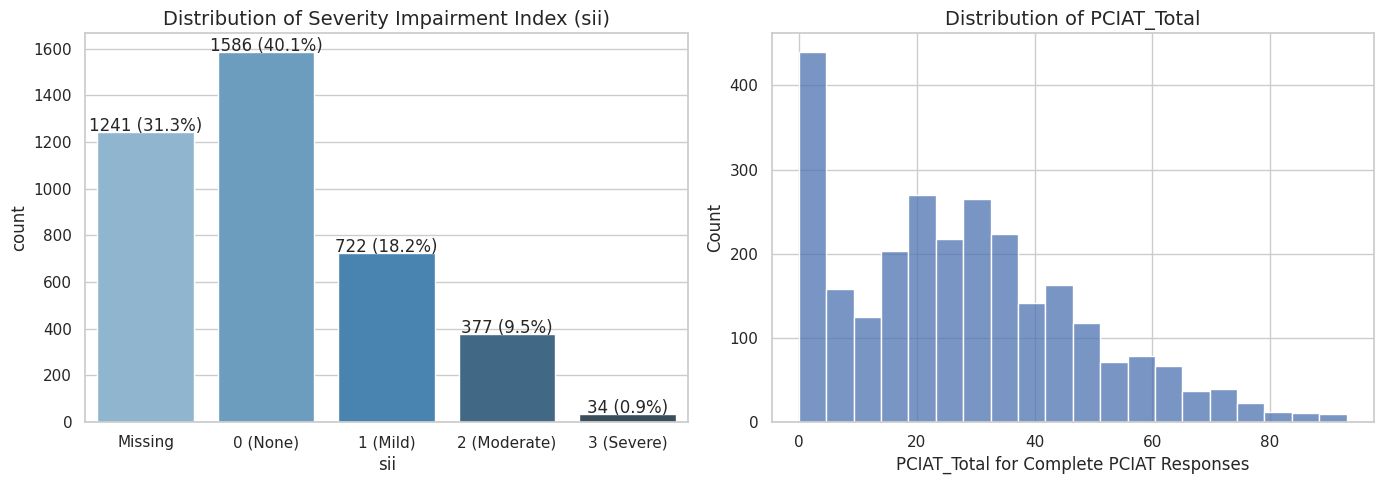

In [22]:
# 目的変数のプロット分布
sii_counts = train['sii'].value_counts().reset_index()
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

In [23]:
len(train[train['complete_resp_total'] == 0])

307

メモ：参加者の40％はインターネット使用の影響を受けておらず、31％は評価されず、中等度から重度の障害を持つのは少数派（～10％）である。PCIATの全質問で0点を取った参加者が307人いる。

年齢・性別SII

In [34]:
# 欠損値がないか確認
assert train['Basic_Demos-Age'].isna().sum() == 0
assert train['Basic_Demos-Sex'].isna().sum() == 0

In [35]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


In [36]:
sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)
calculate_stats(train, 'Basic_Demos-Sex')

,count (%)
Basic_Demos-Sex,
Male,2484 (62.73%)
Female,1476 (37.27%)


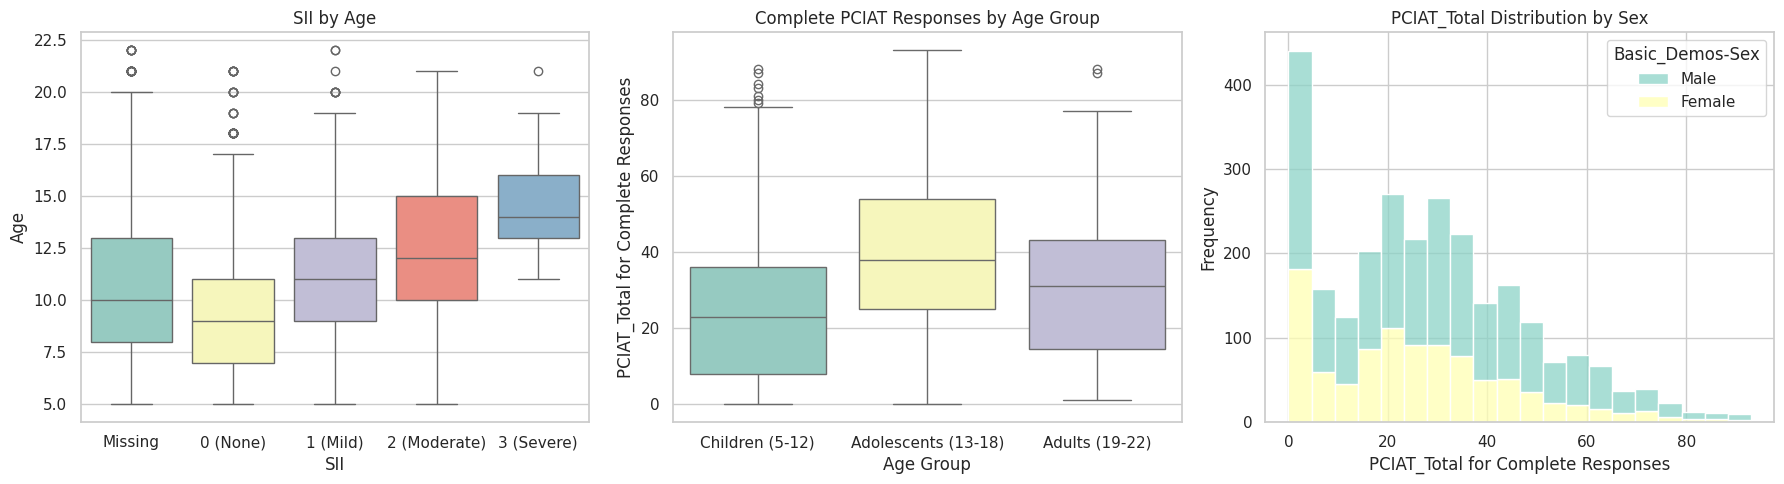

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SII by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['sii'], ax=axes[0], palette="Set3")
axes[0].set_title('SII by Age')
axes[0].set_ylabel('Age')
axes[0].set_xlabel('SII')

# Complete PCIAT Responses by Age Group
sns.boxplot(
    x='Age Group', y='complete_resp_total',
    data=train, palette="Set3", ax=axes[1]
)
axes[1].set_title('Complete PCIAT Responses by Age Group')
axes[1].set_ylabel('PCIAT_Total for Complete Responses')
axes[1].set_xlabel('Age Group')

# PCIAT_Total by Sex
sns.histplot(
    data=train, x='complete_resp_total',
    hue='Basic_Demos-Sex', multiple='stack',
    palette="Set3", bins=20, ax=axes[2]
)
axes[2].set_title('PCIAT_Total Distribution by Sex')
axes[2].set_xlabel('PCIAT_Total for Complete Responses')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

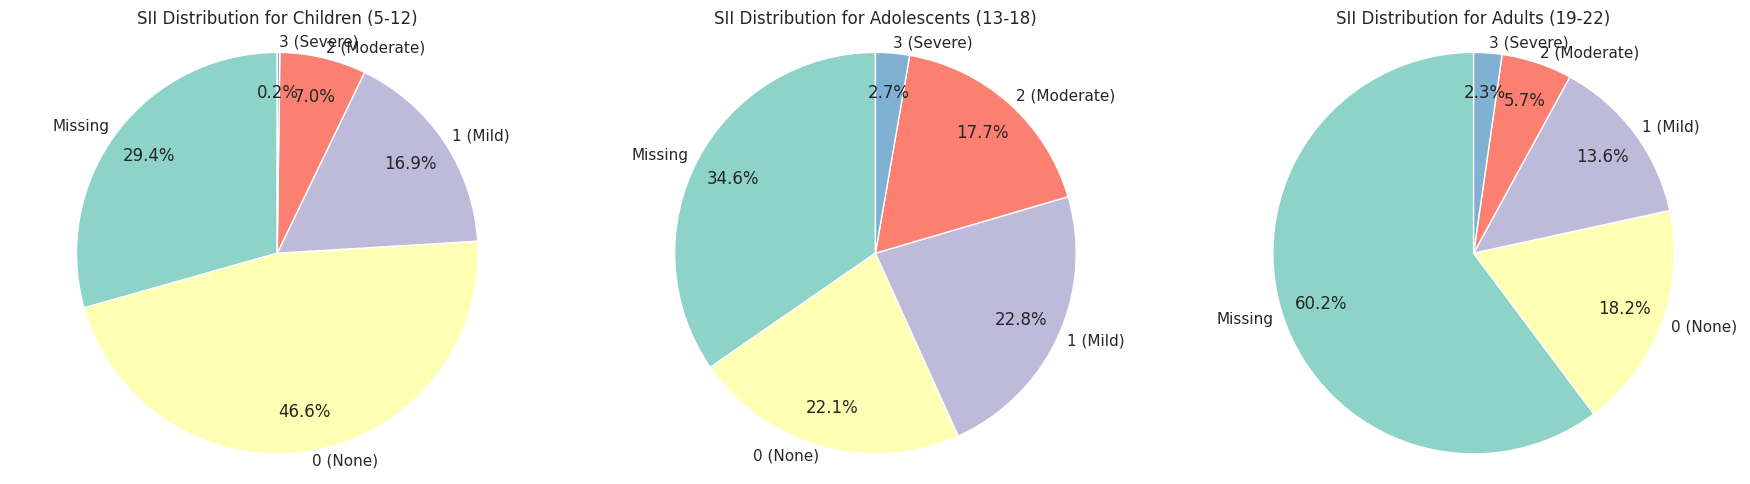

In [40]:
# 異なる年齢層におけるsiiの分布
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [41]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,Missing,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,,
Children (5-12),858 (29.4%),1359 (46.6%),493 (16.9%),203 (7.0%),6 (0.2%)
Adolescents (13-18),330 (34.6%),211 (22.1%),217 (22.8%),169 (17.7%),26 (2.7%)
Adults (19-22),53 (60.2%),16 (18.2%),12 (13.6%),5 (5.7%),2 (2.3%)


In [42]:
# SIIが欠落していない参加者のみのパーセンテージを計算する
stats = train[train['sii'] != 'Missing'].groupby(
    ['Age Group', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,Missing,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,,
Children (5-12),0 (0.0%),1359 (65.9%),493 (23.9%),203 (9.8%),6 (0.3%)
Adolescents (13-18),0 (0.0%),211 (33.9%),217 (34.8%),169 (27.1%),26 (4.2%)
Adults (19-22),0 (0.0%),16 (45.7%),12 (34.3%),5 (14.3%),2 (5.7%)


メモ：
- 箱ひげ図は、カテゴリー化（SII）と数値化（PCIAT_Total）されたターゲット変数の異なる表現である。SIIスコアが高いほど一般的に年齢層が高いが、各カテゴリー内の年齢層にはかなりの重複があり、PCIAT_Totalの中央値は青少年で高く、年齢とPIU障害の間にU字型の関係があることを示唆している（インターネット関連の問題のピークは青少年期に起こる可能性がある）。
- したがって、円グラフでは、子供と成人のSIIの分布は低い値（なしと軽度）に偏っているのに対し、青少年では、なし、軽度、中度のカテゴリー間でよりバランスのとれた分布となっている。
- しかし、数についてはどうだろう（表参照）。青少年の数は子どもの数よりはるかに少なく、成人の参加者の数はきわめて少ない（合計88人、SIIはわずか35人）！
- 前節のグラフからわかるように、SIIの全体的な分布は低い値に偏っており、重症例はまれである。そのため、このようにサンプル数が不均等で、重度症例の割合が低い場合には、見えない関係があるかもしれない。
- 男性と女性の違いは比較的微妙である。